In [1]:
#create dataframe from mySQL server
import pymysql
import pandas as pd

conn=pymysql.connect(host='heatwave2multisource.multisource.prodvcn.oraclevcn.com',port=int(3306),user='abc',passwd='123',db='phong_db')


In [2]:
df = pd.read_sql_query(
""" 
select * from phong_db.customers_multiple_merchants

""",conn)


In [3]:
df['Date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [4]:
df.head()

,concat,fk_customer,id_merchant,merchant_name,date,now,year,month,timestamp,merchant_ranking,Date
0,01b40c65-7f74-4052-ad92-3ccd963a62992b7c91f9-5...,01b40c65-7f74-4052-ad92-3ccd963a6299,2b7c91f9-56f4-4cca-ad9b-793aeb134095,SHEIN,2022-04-09,2022-06-14,2022,4,2022-04-09 04:34:41,1,2022-04-09
1,01b40c65-7f74-4052-ad92-3ccd963a6299dce1da30-e...,01b40c65-7f74-4052-ad92-3ccd963a6299,dce1da30-e47b-47d2-937c-606d55a4a964,Fitness Time,2022-05-31,2022-06-14,2022,5,2022-05-31 22:05:22,2,2022-05-31
2,01b40bff-2d6c-413b-ab00-1f0129c986d293f745d3-d...,01b40bff-2d6c-413b-ab00-1f0129c986d2,93f745d3-d1b5-4a5e-a9e8-deaffdd38336,Floward,2021-09-13,2022-06-14,2021,9,2021-09-13 13:42:26,1,2021-09-13
3,01b40bff-2d6c-413b-ab00-1f0129c986d202189dbf-a...,01b40bff-2d6c-413b-ab00-1f0129c986d2,02189dbf-a1c9-4d37-a6d1-1dba818af244,Specialty Hub,2021-09-28,2022-06-14,2021,9,2021-09-28 10:23:24,2,2021-09-28
4,01b3d922-6d23-445c-914b-684d3ccdaa982b7c91f9-5...,01b3d922-6d23-445c-914b-684d3ccdaa98,2b7c91f9-56f4-4cca-ad9b-793aeb134095,SHEIN,2021-11-25,2022-06-14,2021,11,2021-11-25 03:18:57,1,2021-11-25


In [5]:
from datetime import datetime, timedelta

start_date ='2022-06-01'
start_date=datetime.fromisoformat(start_date).date()
end_date = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d')
end_date=datetime.fromisoformat(end_date).date()

In [6]:
import datetime

df_append = []

while (start_date  <= end_date):

    df_s=df[df["Date"]== start_date.strftime('%Y-%m-%d')]
    df_before=df[df["Date"] < start_date.strftime('%Y-%m-%d')]    
    
    df1 = df_s[['fk_customer','id_merchant','merchant_name','Date']].drop_duplicates()
    df1.reset_index(drop=True)
    df1.rename(columns = {'merchant_name':'new'}, inplace = True)
    df_before = df_before[['fk_customer','id_merchant','merchant_name']].drop_duplicates()

    df2 = df_before.groupby(["fk_customer"])['merchant_name'].apply(list).reset_index(name='old')
    df3=df1.merge(df2,on=['fk_customer'], how='left')

    df3['new'] = df3['new'].astype(str)
    df3['old'] = df3['old'].astype(str)

    df3['old'] = df3["old"].str.replace("]","")
    df3['old'] = df3["old"].str.replace("[","")
    df3['old'] = df3["old"].str.replace("'","")

    df3['flag'] = df3.apply(lambda x: x.new in x.old, axis=1)   
    
    # filter the existing customers acquisition
    df4 = df3[df3['flag'] == False ]

    # counting the number of existing customer acquisition by merchant
    df5 = df4.groupby(['Date','new'])['fk_customer'].nunique().to_frame(name = 'count').reset_index()

    df_append.append(df5)
    
    
    start_date = start_date + datetime.timedelta(days=1) 

 

C:\Users\NGUYEN~1\AppData\Local\Temp/ipykernel_6856/2959973059.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3['old'] = df3["old"].str.replace("]","")
C:\Users\NGUYEN~1\AppData\Local\Temp/ipykernel_6856/2959973059.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3['old'] = df3["old"].str.replace("[","")


In [7]:
df6 = pd.concat(df_append)
df7 = df6.groupby('Date')['count'].sum()
df8 = pd.DataFrame(df7)

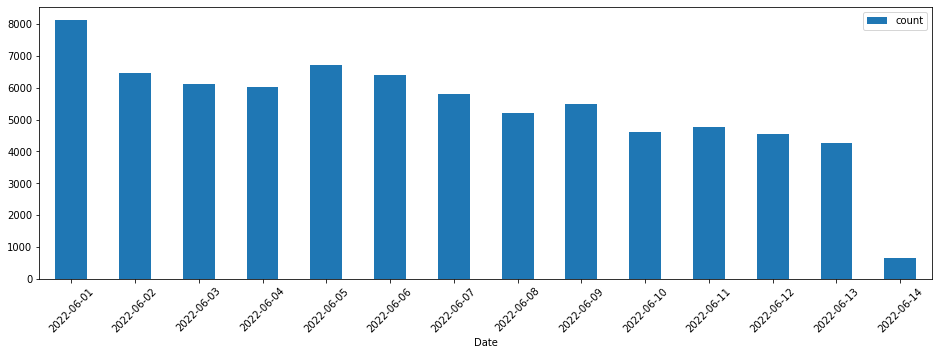

In [8]:
# plot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
df8.plot(kind="bar", figsize=(16,5), stacked=True, ax=ax)

# format xtick-labels with list comprehension
ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in df8.index], rotation=45)
plt.show()